# Analysis of Rhythmic Spiking in the Subthalamic Nucleus During a Movement Task

<div class="question">
    
_**Synopsis**_ 

**Data:** Spiking activity from one neuron over 50 trials each of 2 s duration.


**Goal:** Characterize and interpret features of rhythmic spiking activity.


**Tools:** ISI histograms, autocorrelation plots, point process spectral estimators, history-dependent generalized linear models.
    
</div>

* [On-ramp: analyzing rhythmic spiking in Python](#onramp)
* [Introduction](#introduction)
    * [Tools](#tools)
* [Data analysis](#data-analysis)
    1. [Visual Inspection](#visual-inspection)
    1. [Point Process Models](#ppm)
    1. [Spectral Analysis of Spiking Data](#spectral-analysis)
    1. [Drawing Conclusions from the Model](#drawing-conclusions)
* [Summary](#summary)

## On-ramp: analyzing rhythmic spiking in Python<a id="onramp"></a>
We begin this notebook with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this notebook: how to analyze rhythmic spiking in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to  illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

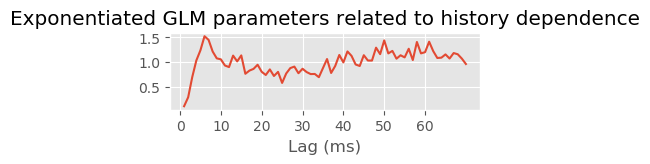

In [1]:
# Import the usual suspects ...
from scipy.io import loadmat            # To load .mat files
from pylab import *                     # Import plotting functions

# ... and the modules we need for this notebook
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from pandas import concat

data = loadmat('matfiles/10_spikes-1.mat')          # Load the spike train data.
t = data['t'][0]                        # Extract the t variable.
direction = data['direction'].flatten() # Extract the direction variable.
train = data['train']                   # Extract the train variable

nTrial, nTime = train.shape             # Number of trials and number of time points.
IMove = tile(t >= 0, nTrial)            # Define movement period.
IDir = repeat(direction == 1, nTime)    #  Define direction of movement
spikes = train.flatten()                # Reshape  trials into a single vector
                                        # Create a dataframe with the data to fit
glmdata = df({'IMove': IMove, 'spikes': spikes, 'IDir': IDir})

ordK = 70                               # Define the model order for spike history.
for k in range(1, ordK + 1):            # For each lag,
                                        # ... add spiking history to dataframe.
    glmdata['lag{:02d}'.format(k)] = roll(glmdata.spikes, k)  

glmdata['Time'] = tile(t, nTrial)       # Add a Time to dataframe.
                                        # Reference only times >= ordK
glmHist = glmdata.loc[lambda d: d['Time'] > t[ordK]]
                                        # Create a string with all lag columns
lagColumns = ' + '.join(glmHist.filter(like='lag', axis=1))

# Model formula: spikes as a function of IMove, IDir and history
formula = 'spikes ~ IMove + IDir + IMove : ({0})'.format(lagColumns)
                                        # Fit the model
M = smf.glm(formula=formula, data=glmHist, family=Poisson()).fit()
                                        # Plot history dependence during planning period.
plot(range(1, ordK + 1), exp(M.params[3::2]))
xticks(range(0, 70, 10))                # With axes labeled.
xlabel('Lag (ms)')
title('Exponentiated GLM parameters related to history dependence');

<div class="question">

**Q:** Try to read the code above. Can you see how it loads data, builds a statistical model of the data with history dependence, and fits the model?

**A:** If you've never created a statistical model with history dependence before, that's an especially difficult question. Please continue on to learn this **and more**!

</div>

## Introduction<a id="introduction"></a>

### Background

The subthalamic nucleus (STN) is a component of the basal ganglia that is thought to play an important role in the regulation of motor function. Neurons in the STN often have rhythmic spiking dynamics, and aberrations in the spike rhythms in STN have been associated with tremor and other motor symptoms in Parkinson’s disease. In fact, the STN is one of the primary targets for deep brain stimulation (DBS) to treat Parkinsonian disorders. While the mechanisms by which DBS works are largely unknown, many researchers have hypothesized that altering rhythmic activity in the STN is an important component. Therefore, it is important to be able to characterize spike rhythms in STN neurons and to know with statistical confidence when these rhythms have changed.

In previous notebooks, we developed and used methods to uncover rhythmic dynamics in field recordings. Many of the methods used to characterize rhythms in *spiking data* may be familiar, like autocorrelation functions and spectral estimators, but will require additional care to interpret. In some cases, rhythmic spiking dynamics can be much more subtle than the rhythms identified fields, and statistical modeling methods will be needed to make powerful inferences from spiking data.

### Case Study Data

A clinical neurosurgeon contacts you to help her analyze spiking data she collects from patients with Parkinson’s disease during surgery to implant DBS electrodes. She is interested in making sure that the electrode is localized properly in the STN, and in studying the role that STN activity plays in movement planning and execution for these patients. She asks each patient to perform a simple hand movement task during the electrode implantation procedure, and records the resulting neural activity.

The data consist of single unit spiking activity from one STN neuron recorded over 50 trials of a hand movement task. In each trial, a patient held a joystick and watched cues appear on a screen. The first cue indicated whether the patient should move the joystick to the left or right. The second cue, the GO cue, indicated the time to start moving the joystick. The dataset contains 2 s of activity for each trial, 1 s before the GO cue and 1 s after. We label the period before the GO cue comes on the planning period, and the period after the GO cue the movement period.

### Goal

It is well known that the spiking activity of some STN neurons in patients with Parkinson’s disease shows rhythmic properties in the beta frequency range, 11–30 Hz (<a href="https://doi.org/10.1001/archneurpsyc.1938.02270010106010" target="blank">[Jasper & Andrews, 1938]</a>, <a href="https://doi.org/10.1016/j.neuroimage.2013.05.084" target="blank">[Brittain & Brown, 2014]</a>). The neurosurgeon hypothesizes that information related to the movement task, such as the planning versus the movement period and whether the movement is to the left or right, will influence this rhythmic spiking activity. Our goal is to characterize the spiking properties, identify whether rhythmic activity is present and statistically significant, and how such activity is influenced by the task variables.

### Tools<a id="tools"></a>

We extend some of the tools already developed for studying rhythms and modeling spike trains. Many of the <a href="08" target="_blank">basic visualization tools</a>, such as raster plots, ISI histograms, and autocorrelation functions are useful without modification. We compute spectral estimators for spiking data using the same methods as before, but we have to think carefully about how to interpret the spectrum of a point process. Finally, we extend the <a href="09" target="_blank">GLM methods we previously developed for spike train data</a> to allow us to model history-dependent, non-Poisson spiking processes.

In [2]:
# Import the usual suspects ...
from scipy.io import loadmat                    # To load .mat files
from pylab import *                             # Import plotting and numerical functions

In [3]:
# ... and the modules we need for this notebook
from nitime.algorithms import multi_taper_psd
from nitime.utils import dpss_windows
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from pandas import concat
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm

## Data Analysis<a id="data-analysis"></a>

### Visual Inspection<a id="visual-inspection"></a>

Let’s start by loading the data into Python:

In [4]:
data = loadmat('matfiles/10_spikes-1.mat')           # Load the spike train data.
t = data['t'][0]                         # Extract the t variable.
direction = data['direction'].flatten()  # Extract the direction variable.
train = data['train']                    # Extract the train variable

We find three variables:

  * `direction`: A 50&times;1 vector of indicators for the movement direction for each of 50 trials. A value of 0 indicates movement to the left, and a value of 1 indicates movement to the right.
  
  
  * `t`: A 1&times;2000 vector of time stamps in milliseconds indicating the time into the trial. Time 0 indicates the GO cue.
  
  
  * `train`: A 50&times;2000 matrix of spike counts in each trial and time bin. The rows of the matrix correspond to trials, while the columns correspond to time.

<div class = "question">

**Q:** How many trials involve movment to the left? to the right? 

**A:** To answer this, we must count the number of zeros and ones in direction. The `sum` function provides an efficient method to do so: `sum(direction)` which returns a value of 25. We conclude that half of the 50 trials involve right movement, and half involve left movement.

</div>

Our first goal is to construct a raster plot to visualize the spikes through time for every trial. There are many ways to create this plot in Python. One simple way is to realize that the matrix consists of a collection of zeros and ones as a function of time and trial, corresponding exactly to the information for the raster plot. We can treat this matrix as an image and visualize it using the `imshow()` function in Python:<a id="fig:raster"></a>

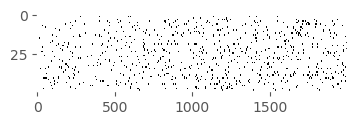

In [5]:
imshow(train, aspect='auto',cmap='gray_r')
show()

Here, we have adjusted the colormap to draw black ticks on a white background for clarity and ease of visual inspection.

Visually, we do not observe much obvious structure in the raster plot. There does not seem to be substantially more spiking either before or after the GO cue. It is also difficult to see any effect of the movement direction for each trial, since left and right trials are interspersed. We can remedy this by grouping all 25 of the left trials together, and all 25 of the right trials together, and generating a new set of raster plots for each trial type.

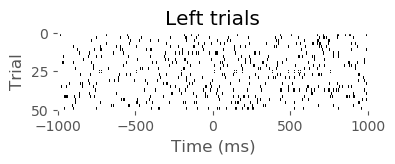

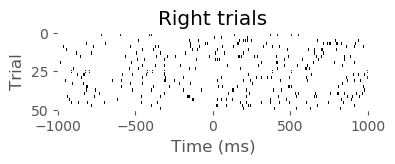

In [6]:
Ltrials = where(direction==0)   #Identify left trials,
Rtrials = where(direction==1)   #... and right trials.
imshow(train[Ltrials], aspect = 'auto', cmap='gray_r', extent = (-1000,1000,50,0))  # Image left trials,
xlabel('Time (ms)')
ylabel('Trial')
title('Left trials')
show()

imshow(train[Rtrials], aspect = 'auto', cmap='gray_r', extent = (-1000,1000,50,0))  # ... and right trials.
xlabel('Time (ms)')
ylabel('Trial')
title('Right trials')
show()

<div class="question">
    
**Q:** Consider the raster plots for the left and right trials in the above figure. Do you notice any difference in spiking between the two trial types? Is rhythmic spiking apparent?
    
**A:** In the separate raster plots we observe slightly more spiking during left trials than during right trials, both during the planning (before time 0 s) and movement (after time 0 s) periods. However, we do not observe in this raster plot clear evidence of rhythmic spiking. There are places where you might convince yourself that rhythmic spiking is present, but it is not clear whether this structure is real or could occur by chance.

</div>

Often when people think about rhythms in spiking data, they think about spiking occurring almost perfectly regularly at some fixed frequency, like a metronome. However, it is rare to find neural spiking systems with this kind of regularity. Instead, if we think about spiking activity as arising from a random point process, we can consider rhythmic spiking as the influence of past spiking on the probability of observing a spike at some time in the future. In other words, another way to think about rhythmic spiking is as a history-dependent point process. Later, we build specific probability models to capture this history dependence. But first we visualize the other influences in the data, those related to planning and movement, and to direction.

We initially construct a **peristimulus time histogram** (PSTH). These PSTHs are useful for visualizing the relation between spike rates and the time relative to a specific time point in repeated trial data. In this case, we look at the spiking rate relative to the time of the GO cue. To compute the PSTH, we partition the time interval into bins, add up the number of spikes that occur within each bin over all trials, and then divide by the number of trials and by the length of the bin. Most often, we select a fixed time width for all the bins.

The matrix `train` already contains the binned spiking data, where the bins are each 1 ms in duration. If we want to use 1 ms bins for the PSTH, all that needs to be done is to sum over all the trials and scale by the number of trials and bin length.

In [7]:
PSTH = sum(train) / 50 / 1e-3

Here we divide by 50 because we sum the spiking over 50 trials, and we divide by 1e-3 = 0.001 because the bin width is 1 ms = 0.001 s, and we would like to express the rate in units of spikes/s, or Hz. However, this method will only work for 1 ms bins. A more general approach is to find the times of all the spikes and use the `histogram` command to compute the PSTH:

In [8]:
spiketrials, spiketimes = where(train)
hist = histogram(spiketimes,2000)[0]/50/1e-3

Either method produces the same PSTH result. Now let’s use the `bar` function to produce a bar graph of the PSTH:

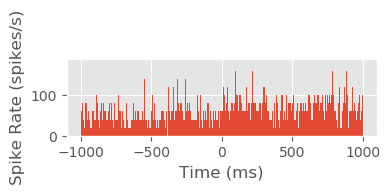

In [9]:
bar(t, hist, 2) 
xlabel('Time (ms)')
ylabel('Spike Rate (spikes/s)')
show()

Although it was not immediately clear from the raster plot, it is evident in the PSTH that there is a difference in the firing rate between planning and movement periods. The firing rate during planning (time < 0 ms) appears to average around 60 spikes/s, and the firing rate during movement (time > 0 ms) appears to be slightly elevated, averaging around 80 spikes/s. However, this PSTH may be a bit misleading because of the very small bin widths used. In each bin, the PSTH only appears to take a few discrete values (e.g., 40, 60, 80 spikes/s) with nothing in between. Also, there are many bins where the PSTH value is equal to zero; these bins are not obvious in the figure because they are masked by nearby bins. The initial PSTH therefore gives a false sense of the average spike rate. To investigate further, let’s increase the PSTH bin width:

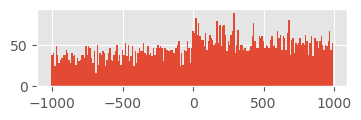

In [10]:
PSTH10 = histogram(spiketimes, 200)[0]                  #Compute histogram using 10 ms bins
bar(t[arange(0, 2000, 10)], PSTH10/50/10*1000,width=10) #... and plot it.
show()

<div class="question">
    
**Q:** How does the second input to the hist function specify 10 ms bins?

</div>

With 10 ms bin widths, the difference in firing rate between planning and movement periods is still evident, but we see that we had overestimated the firing rate because bins with small PSTH values were masked by neighboring bins with higher values. Now we find that the average firing rate during planning is closer to 35 spikes/s, while the rate during movement is closer to 55 spikes/s.

<div class="question">
    
**Q:** Construct a PSTH for these data with 100 ms bins. How does the result compare to the 10 ms bin PSTH in the above figure? What might be some issues that impact PSTHs with large bin widths? What do you think might be a good way to select bin widths for a PSTH?

</div>

We can also compute the average spike rate in the movement and planning periods directly. To do so, we need to average the spiking data over both trials and time in each period.

In [11]:
i_plan = where(t < 0)[0]                   #Indices for planning.
i_move = where(t >= 0)[0]                  #Indices for movement.
                                           #Compute the average spike rate,
PlanRate = mean(train[:, i_plan]) / 1e-3   #...during planning,
MoveRate = mean(train[:, i_move]) / 1e-3   #...during movement.

Executing these commands, we find `PlanRate = 38.96`, and `MoveRate = 54.96`. These results are consistent with our estimation of the average firing rates through visual inspection of the histogram with 10 ms bins.

In addition to the planning and movement periods, the task can be broken down based on the direction of movement that is cued. The variable direction contains an indicator variable for each trial, which is 0 for left trials and 1 for right trials. Since the left and right trials are interspersed, we need to first find which trials correspond to each direction, and then compute the firing rates for each type of trial.

In [12]:
Ltrials = where(direction==0)           #Find left trials,
Rtrials = where(direction==1)           #... and right trials,
LRate = mean(train[Ltrials, :]) / 1e-3  #... and compute rates.
RRate = mean(train[Rtrials, :]) / 1e-3

<div class="question">
    
**Q:** What do you conclude about the firing rates for the two types of trials?

**A:** Upon executing these commands, we find `LRate = 58.66` and `RRate = 35.26`. These results suggest that the spiking rates for planning and movement in left trials are higher than the rates for right trials.

</div>

We have now shown that the average firing rate changes between planning and movement periods, and between left and right trials. One question that arises is how the changes pertaining to trial period and to trial direction are related. We have four categories to explore: planning for left trials, planning for right trials, movement on left trials, and movement on right trials. We could compute the mean firing rates in each of these categories. Instead, let’s examine the trial-to-trial distribution of firing rates in each category. Let’s sum the spiking over each 1 s planning or movement period for each trial type, and generate a box plot that visualizes these distributions:

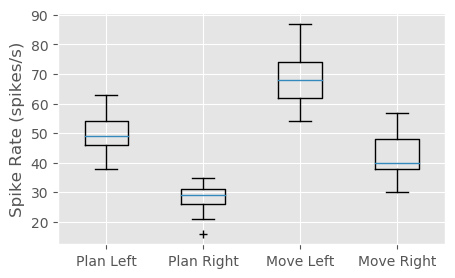

In [13]:
PlanL = sum(train[Ltrials][:,i_plan], axis = 1)   # Firing rate L, planning.
PlanR = sum(train[Rtrials][:,i_plan], axis = 1)   # Firing rate R, planning.
MoveL = sum(train[Ltrials][:,i_move], axis = 1)   # Firing rate L, movement.
MoveR = sum(train[Rtrials][:,i_move], axis = 1)   # Firing rate R, movement.
figure(figsize=(5, 3))
boxplot([PlanL, PlanR, MoveL, MoveR], sym='+', 
        labels = ['Plan Left', 'Plan Right', 'Move Left', 'Move Right'])
ylabel('Spike Rate (spikes/s)')
show()

<div class="question">
    
**Q:** Have you used the function `boxplot` before? If not, <a href="https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.boxplot.html" target="blank">look it up</a>.

</div>

<div class="question">
    
**Q:** How do the variables in this code correspond to firing rates?

**A:** In this case, the duration of the interval is 1 s for both planning and movement periods. Therefore, we may think of dividing each sum by 1 s, which does not affect the numerical values in the variables.

</div>

The box plot corroborates our previous findings that the firing rate is increased in left trials and in the movement period of each trial. Further, it suggests that these effects may occur independently and additively; the difference between left and right trials seems approximately the same for both planning and movement periods. At this stage, it would be natural to ask whether these differences between mean firing rates are statistically significant. We explore issues of significance later, and discuss why some traditional approaches for comparing means across groups (such as *t*-tests between pairs or analysis of variance between all groups) might not capture the structure in the data very well.

While these visualizations have helped elucidate the long-term spiking structure over periods of about 1 s, they have not provided much information about short-term rhythmic structure. In <a href="08" target="_blank">notebook 8</a>, we used interspike interval (ISI) histograms to help visualize fine time scale history dependence in spiking activity. Let’s do so again here. To compute the ISI histogram, we first need to compute the ISIs. One approach is to write a for-loop that iterates through each trial in the `train` matrix, finds the spike times, and computes the ISIs. However, in constructing the PSTH, we computed the variable `spiketimes`, which already contains the spike times in trial 1, followed by the spike times in trial 2, and so on, all in one array. If we compute the differences in these spike times, we will have the ISIs for each trial mixed with an occasional negative value when an element of spiketimes is the first spike time for any trial. Let’s eliminate these spurious values and plot a histogram of the ISIs:

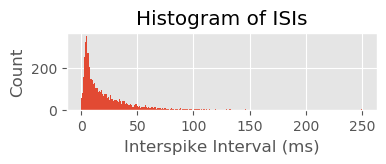

In [14]:
ISIs = diff(spiketimes)                     #Compute ISIs for all trials,
ISIs = ISIs[where(ISIs > 0)]                #... and ignore ISIs "across trials"
hist = histogram(ISIs, 250)[0]              #Compute histogram of ISIs,
bar(linspace(0, 250, 250), hist, width = 1) #... and plot it.
xlabel('Interspike Interval (ms)')
ylabel('Count')
title('Histogram of ISIs')
show()

<div class="question">
    
**Q:** Can you think of a way this code might lead to incorrect computation of the ISIs? Did this happen for this dataset?

**A:** If the last spike in any given trial occurred at an earlier time than the first spike in the subsequent trial, then the ISI computed between trials would not be negative and would not be removed. This never happens in these data, but it suggests that we should be careful when we code various procedures to think about the possible outcomes.

</div>

The ISI histogram in the above figure reveals a few interesting features, including a short relative refractory period (fewer ISIs near 0 ms) and a large number of ISIs near about 6 ms, suggesting bursting activity (i.e., times of rapid spiking with small intervals between spikes). However, it is difficult to see any structure that looks like clear rhythmic spiking, such as a large second peak at longer ISIs. Let’s see if there is a difference in the ISI distributions for planning and movement periods:

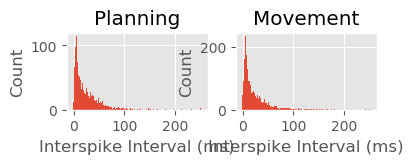

In [15]:
#In the planning period,       
spiketrialsPlan, spiketimesPlan = where(train[:,i_plan] > 0) #Find spikes
PlanISIs = diff(spiketimesPlan)                              #... compute ISIs,
PlanISIs = PlanISIs[where(PlanISIs > 0)]                     #... drop spurious ones.
planhist = histogram(PlanISIs, 250)[0]

subplot(121)
bar(linspace(0, 250, 250), planhist, width = 2)              #Plot ISIs,
xlabel('Interspike Interval (ms)')                           #... label axes.
ylabel('Count')
title('Planning')

#In the movement period,       
spiketrialsMove, spiketimesMove = where(train[:, i_move] > 0)#Find spikes
MoveISIs = diff(spiketimesMove)                              #... compute ISIs,
MoveISIs = MoveISIs[where(MoveISIs>0)]                       #... drop spurious ones.
movehist = histogram(MoveISIs, 250)[0]

subplot(122)
bar(linspace(0, 250, 250), movehist, width = 2)              #Plot ISIs,
xlabel('Interspike Interval (ms)')                           #... label axes.
ylabel('Count')
title('Movement')
show()

<div class="question">
    
**Q:** What features differ between the ISI histograms for the planning and movement periods, shown above?

**A:** There are a few notable differences between the ISI histograms in the two periods. The total number of ISIs is larger during the movement period, corroborating our earlier finding that the firing rate is higher during this period. The peak in the ISI distribution around 6 ms seems more pronounced during movement, suggesting a higher tendency to fire in bursts. There may be some differences in the tail structure of the ISI distribution at ISI values above 20 ms, but it is difficult to relate this to differences in rhythmic spiking structure.

</div>

In <a href="08" target="_blank">notebook 8</a>, we also used the sample **autocorrelation function** (ACF) to visualize history-dependent spiking properties. Recall that the ACF shows the correlation between a signal at two points in time separated by a fixed lag, evaluated over different values of the lag. For these spike train data, let’s use the increments (i.e., the number of spikes in each time bin) as the signal, compute the ACF for each trial, and average the results over all the trials.

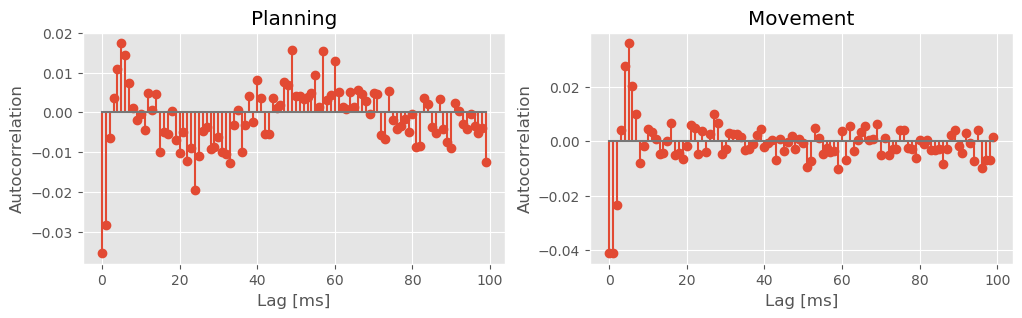

In [16]:
acf1 = zeros((50, 1999))     #Variable to hold ACF during planning,
acf2 = zeros((50, 1999))     #... and during movement.

for k in range(50):          #For each trial,
    plan = train[k, i_plan]  #... get planning data,
    move = train[k, i_move]  # ... get movement data,
    corr1 = correlate(plan - mean(plan), plan - mean(plan), 'full') #Compute ACF,
    acf1[k] = corr1 / linalg.norm(plan - mean(plan))**2             #... and normalize,
    corr2 = correlate(move - mean(move), move - mean(move), 'full') #... for both conditions.
    acf2[k] = corr2 / linalg.norm(move - mean(move))**2 
    
figure(figsize=(12, 3))
subplot(121)                 #Show the ACFs
stem(mean(acf1[:,1000:1100], axis = 0), use_line_collection=1)
xlabel('Lag [ms]')
ylabel('Autocorrelation')
title('Planning')

subplot(122)
stem(mean(acf2[:,1000:1100], axis = 0), use_line_collection=1)
xlabel('Lag [ms]')
ylabel('Autocorrelation')
title('Movement')
show()

<div class="question">
    
**Q:** Why do we examine the variables `acf1` and `acf2` at columns `1000:1100`?

**A:** The columns of both matrices specify the lags, which extend from -1 s to +1 s. We choose indices `1000:1100` to investigate positive lags beginning at 1 ms and ending at 100 ms. Notice that we compute the mean of both matrices across trials (rows) before displaying the results.

</div>

The autocorrelation plots for both the planning and movement periods show very clear structure. In both periods we see negative correlation for lags of 1–3 ms, followed by positive correlation at lags of 1–8 ms, with a peak at a lag of 6 ms. During the planning period, we see clear structure continuing at higher lags, with an extended period of negative correlations at lags of about 15–35 ms and positive correlations at lags of about 50–70 ms. For the movement period, this structure at lags longer than about 10 ms seems reduced or even absent. These results suggest a change in the rhythmic firing properties between the planning and movement periods. The second peak in the autocorrelation plot for the planning period around 60 ms suggests a 1/60 ms $\approx$17 Hz rhythm that disappears during movement.

[Back to top](#top)

## Spectral Analysis of Spiking Data <a id="spectral-analysis"></a>

So far, we have focused on statistical characterizations of spike trains in the time domain. Another approach to visualizing and describing structure in point processes focuses on estimating rhythmic (or harmonic) features of the data in the frequency domain. In <a href="03" target="_blank">notebooks 3</a> and <a href="04" target="_blank">4</a>, we discussed methods to decompose field data (or continuous valued functions and random processes) into harmonic components. The same type of approach can be used to decompose point processes and to determine the relative contributions to their variability attributable to each frequency. Point process spectral estimation provides a useful tool for spike train analysis but should be performed with care. On the one hand, computing spectral estimates for discrete spike train data is similar to the approaches used for continuous valued signals. On the other hand, the interpretation of point process spectra can differ from continuous process spectra, and blindly applying intuition from continuous spectral estimation to point process data can lead to incorrect interpretations.

### Point Process Spectral Theory

In this section, we develop some of the theory needed to understand and interpret spectral estimators for spiking data. As with the spectrum for continuous valued processes (<a href="03" target="_blank">notebook 3</a>), the spectrum for a point process can be expressed as the Fourier transform of its autocovariance function. In discrete time, assume we have binned the spiking activity into intervals of length $\Delta t$, and that $\Delta N_i$ represents the number of spikes fired in the $i^{th}$ interval, which is called the $i^{th}$ increment. The autocovariance sequence is then

\begin{align}
\gamma(h) &=E[(\Delta N_i - \lambda_0\Delta t)( \Delta N_{i+h} - \lambda_0\Delta t)]\\
&=E[\Delta N_i \Delta N_{i + h}] - (\lambda_0 \Delta t)^2
\end{align}

where  $\lambda_0 \Delta t$ is the expected number of spikes in a single time bin. The discrete spectrum is the discrete Fourier transform of this sequence. Using this definition, we can compute the theoretical autocovariance and spectrum for any stationary point process model.

**Example 1: Spectral density of a homogeneous Poisson process.**

For a homogeneous Poisson process, the increments $\Delta N_i$ are independent, and each has a Poisson distribution with the same mean. Assume the mean number of spikes in any bin is  $\lambda_0 \Delta t$. Since the mean and variance of a Poisson random variable are the same (see <a href="08" target="_blank">notebook 8</a>), this is also the variance of any increment. The autocovariance at lag $h = 0$ is just the variance of $\Delta N_i$, which is  $\lambda_0 \Delta t$. At any other lag, the increments are independent and therefore the autocovariance is zero. The autocovariance function is therefore given by

<p title="homogeneous">
$$
  \gamma(h) = \begin{cases}
  \lambda_0 \Delta t & \text{if }h = 0,\\
  0 & \text{otherwise}.\\
  \end{cases}
$$
</p>

The spectral density of this homogeneous Poisson process is the Fourier transform of this autocovariance sequence in the limit as $\Delta t \to 0$, which is

$$
  F(\omega)=\lambda _ 0.
$$

The Fourier transform $F(\omega)$ does not vary as a function of $\omega$, that is, the spectral density is flat. This suggests that constant power is required at all frequencies to describe a homogeneous Poisson process. This is the point process analogue of white noise.

**Example 2: Spectral density of a refractory point process.**

Assume now that we modify the spiking process to include a relative refractory period. We do this by adding a negative autocorrelation at small lags that diminishes in magnitude as the lag increases. Thus, a spike 1 ms in the past would substantially decrease the probability of observing another spike in the current time interval, but a spike many milliseconds in the past would have little to no effect on the current spike probability. Mathematically, we assume that the autocovariance function has the form

$$
  \gamma(h) = \begin{cases}
  \lambda_0 \Delta t  - \alpha f_{\sigma}(h) & \text{if }h = 0,\\
  -\alpha f_{\sigma}(h) & \text{otherwise},\\
  \end{cases}
$$

where $\alpha$ is a constant representing the degree of refractoriness, and $f_{\sigma}(h)$ is the Gaussian function (or equivalently, the normal probability density function) with a mean of zero, and a standard deviation of $\sigma$. Let's define some functions so that we can look at some examples of how different values of ${\sigma}$ affect $\gamma(h)$.

In [17]:
# Define f_sigma(h) as a gaussian with default mean (mu=0) and standard deviation (sig=1)
def gaussian(x, mu=0, sig=1):
    return exp(-pow(x - mu, 2) / (2 * pow(sig, 2)))

# Define some default parameter values for the autocovariance function
lbda0, alpha, dt = .01, 1e-4, 1e-3

# Define the ACF gamma, again with some default values for the parameters
def gamma(lag, sig, lbda0=lbda0, dt=dt, alpha=alpha):
    if lag==0:
        return lbda0 * dt - alpha * gaussian(lag, sig=sig)
    else:
        return -alpha * gaussian(lag, sig=sig)
    

Now that we have the functions, try plugging in different values of `sig`.

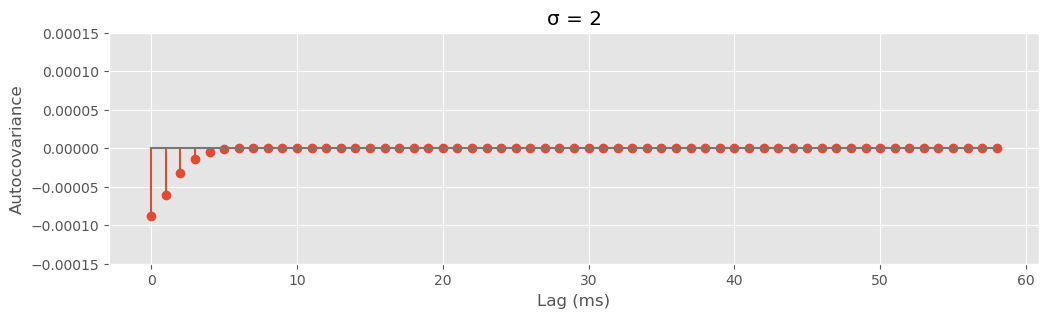

In [18]:
sig = 2  # Change the value here to see how the autocovariance changes
autocov = [gamma(lag, sig) for lag in range(1, 60)]

figure(figsize=(12,3))
stem(autocov,use_line_collection=1)
xlabel('Lag (ms)')
ylabel('Autocovariance')
title('σ = {:}'.format(sig))
ylim([-1.5e-4, 1.5e-4])
show()

The reason we chose the Gaussian function is that it captures a smooth decay of the refractory effect and its Fourier transform is easy to compute. The spectral density $F(\omega)$ of this refractory point process is
$$
  F(\omega)  = \lambda_0 - \alpha \sqrt{2\pi\sigma} \cdot f_{1/\sigma} (\omega).
$$

This spectral density does depend on $\omega$; as $\omega$ becomes large, $f_{1/\sigma}(\omega)$ goes to zero and the spectrum approaches the constant level of a Poisson process; however, as $\omega$ becomes small, the spectrum decreases below this level. Therefore, the effect of the refractory period on the spectrum is a dip at low frequencies. Adjust the value of `sig` in the following code block to verify this for different values of $\sigma$.

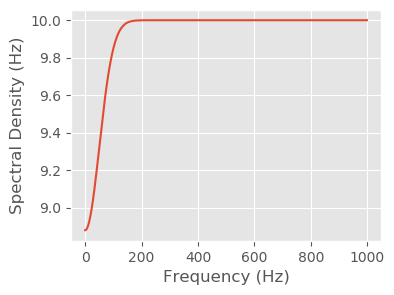

In [19]:
sig = 20                         #Set the width of the refractory period,
spectral_density = (lbda0 -     #... and compute the spectral density.
                    alpha * sqrt(2 * pi * sig) * 
                    gaussian(arange(0, 1, dt), sig=1/sig))
figure(figsize=(4,3))
plot(spectral_density * 1 / dt)  #Plot the spectral density in Hz,
xlabel('Frequency (Hz)')         #... with axes labeled.
ylabel('Spectral Density (Hz)')
show()

You should observe that the extent of this decrease in power in the frequency domain is inversely proportional to the extent of the refractory period in the time domain. When $\sigma= 2$ ms, the dip in the spectrum is small but extends all the way out beyond 500 Hz. If you evaluate $\sigma= 20$ ms, for example, the dip in the spectrum is larger but only extends out to about 100 Hz.

It may seem strange that considerable power remains at high frequencies even though the refractory period decreases the probability that the spike train fires at frequencies higher than $1/\sigma$ . The explanation for this apparent incongruity is that the high-frequency power is not only related to the probability of firing at high frequencies but is also necessary to generate the impulse profile of each spike event. As frequency becomes large, the power spectral density of any point process will asymptote to $\lambda_0$, the expected spike rate, not to zero.

This example illustrates a counterintuitive result. To understand the mean firing rate of a spiking process, we look to the high end of the spectrum, and to understand whether refractoriness prevents high-frequency spiking, we look to the low end of the spectrum. This is one reason it is important to be careful when interpreting spectral estimators for point processes.

### Spectral Estimates for the STN Data

With a new appreciation for interpreting point process spectra, let’s compute spectral estimators for the STN data for the planning and movement periods. As in notebooks <a href="04" target="_blank">4<a href="05" target="_blank">/a> and [5</a>, we use multitaper spectral estimators. Since the data follow a trial structure, we compute estimators for each trial and average the results across trials. The planning and movement periods for each trial are 1 s in duration, so we can achieve a 4 Hz frequency resolution by setting the time-bandwidth product to 4. This allows us to use seven tapers, each providing independent and informative estimates.

<div class="python-note">

Here we compute the spectrum by hand. The main reason for this is that we are working with point process data and most packages assume that a signal is continuous. Below, we define a function, `mt_spec` to calculate spectrum. The line marked with a pair of asterisks (**) is where the computation of the spectrum of point process data differs from that of continuous data. In this case, because the mean firing rate is so low, the difference is trivial. Using the `multi_taper_psd()` function from the <a href="http://nipy.org/nitime/documentation.html" target="_blank">Nitime</a> package produces nearly the same result, though it must be rescaled to see this. Try the following to compare results from the packaged function to those from the function we define below.

    from nitime.algorithms import multi_taper_psd
    f, SPlanP, var = multi_taper_psd(train[:, i_plan] * Fs, Fs=1000, NW=4)
    SPlan *= Fs ** 2 / 2

</div>

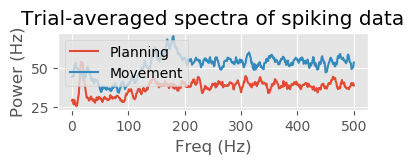

In [20]:
def mt_specpb(data, Fs=1000, NW=4, trial_ave=True):
    
    tapers, _ = dpss_windows(data.shape[-1], NW, 2*NW-1) # Compute the tapers,
    tapers *= sqrt(Fs)                                   # ... and scale them.
    
    dataT = [[trial * t for t in tapers]                 # Multiply the data by the tapers,
             for trial in data]                          # ... for each trial in the data.
    T = rfft(tapers)                                 # Compute the fft of the tapers.
    J = rfft(dataT)                                  # Compute the fft of the tapered data.
    # Recall that rfft assumes the data are real, and thus 
    J -= [T * trial.mean() for trial in data]            # Subtract the dc (**)
    J *= J.conj()                                        # Compute the spectrum
    S = J.mean(1).real
    f = rfftfreq(data.shape[-1], 1 / Fs)
    if trial_ave : S = S.mean(0)                         # Average across trials.
    return f, S


f, SPlan = mt_specpb(train[:, i_plan])  # Compute the spectrum of the planning period
_, SMove = mt_specpb(train[:, i_move])  # ... and the movement period

plot(f, SPlan, label="Planning")        # Plot the planning period,
plot(f, SMove, label="Movement")        # ... and the movement period
xlabel('Freq (Hz)')                     # ... with axes labeled
ylabel('Power (Hz)')
legend()
title('Trial-averaged spectra of spiking data');

A number of distinct features are evident in these spectral estimates for the planning and movement periods. At higher frequencies, the spectral density for the planning period asymptotes to about 35 Hz, while for the movement period it asymptotes closer to 55 Hz. This corroborates our previous results based on the observed mean firing rates. Both spectral estimates show a decrease at frequencies below 200 Hz, suggesting an approximately 5 ms refractory period. However, in the planning period, we see a large peak at about 18 Hz that does not appear during the movement period. This suggests that the STN neuron spikes rhythmically during the planning period and that this rhythm is attenuated during movement.

Here we have separated each trial into planning and movement periods and computed separate spectral estimates for each period. This assumes that the data are stationary—that the mean and autocovariance structure do not change in time—during the planning period, that there is a sudden change between the planning and movement period, and that the data are stationary again during the movement period. Is this a reasonable assumption? One way to explore this is to compute a spectrogram, as we did in <a href="03" target="_blank">notebook 3</a>. Let’s use a moving window of 500 ms duration and a step size of 50 ms.

<div class="question">

**Q.** Since the duration of the moving window is 500 ms, if we want to maintain a frequency resolution of 4 Hz, what is the time-bandwidth product and number of tapers?

**A.** The time-bandwidth product is 0.5 s &times; 4 Hz = 2. In this case, we therefore have three tapers that provide informative, independent estimates of the spectrum.

</div>

We also focus on the frequency range from 0 to 50 Hz, which includes the large peak near 18 Hz that we previously observed during the planning period.

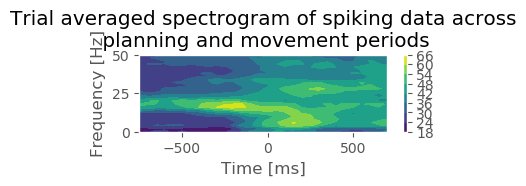

In [21]:
window, step = .5, .05  # Define the duration and step size for the spectrogram in seconds.
fpass = [0, 50]         # Define the frequency band of interest,
Fs = 1000               # ... and sampling rate.

window, step = [int(Fs * x) for x in [window, step]]  # Convert step and window to samples.
starts = range(0, train.shape[-1] - window, step)     # Determine where spectrogram windows should start.
f = mt_specpb(train[:, range(window)], NW=2)[0]       # Get the frequencies,
findx = (f >= fpass[0]) & (f <= fpass[1])             # ... create a mask of frequencies of interest,
f = f[findx]                                          # ... and select these frequencies of interest.
spectrogram = [mt_specpb(train[:, range(s, s + window)], NW=2)[1][findx]  # Compute the spectrum on each 500 ms window.
               for s in starts]                       # ... starting every 50 ms

T = t[starts] + window / 2                            # Centers of spectrogram windows.
contourf(T, f, array(spectrogram).T)                  # Plot the result,
xlabel('Time [ms]')                                   # ... with axes labeled.
ylabel('Frequency [Hz]')
title('Trial averaged spectrogram of spiking data across\n planning and movement periods')
colorbar()
show()

<div class="question">
    
**Q.** What features do you observe in the spectrogram of the spike train data? How do these features change between the planning and movement periods?

**A.** The period before time 0 s, corresponding to the planning period, shows a clear peak at 15–20 Hz. As we approach time 0 s, there is a rapid change in the spectral structure. The peak starts to vanish, not only because the spectral density at 15–20 Hz decreases but also because the spectral density across all frequencies increases. This reflects a combination of a change in rhythmic spiking and a change in the overall firing rate. The fact that the spectral content seems to undergo a sudden shift from one regime (planning) to another regime (movement) suggests that it is reasonable to construct models with different spike dynamics in these two periods.

</div>

<div class="python-note">
    
To make the figure above we used the `contour()` function. This function breaks the data into bins and then does some spatial interpolation so that it appears less pixelated. Try using `pcolormesh()` instead of `contour()`. Note: we could have used `imshow()` like we did to make the [raster plots](#fig:raster)<span class="sup">fig<img src="imgs/raster.png"></span>, but labeling the axes with `contour()` and `pcolormesh()` is more straightforward.

</div>

[Back to top](#top)

<a id="ppm"></a>
## Point Process Models

So far we have focused on descriptive statistics and visualization methods to characterize the properties of the spike train data. In <a href="09" target="_blank">notebook 9</a>, we developed point process models to understand the factors influencing a spiking process. We can use the same types of models to describe how past spiking activity influences future activity to produce rhythmic spiking and other forms of history dependence. In doing so, we utilize all the tools that we previously developed for point process modeling: tools to fit parameters and construct confidence bounds, tools to measure the goodness-of-fit between the model and the data, and tools for testing whether individual model components or combinations of components provide significant improvements in fitting the data.

In this case study, we continue to use a specific class of models, **generalized linear models** (GLMs) for point processes. As discussed in <a href="09" target="_blank">notebook 9</a>, GLMs have a number of attractive properties, including the fact that we can guarantee that the likelihood of the data as a function of the model parameters is convex and therefore has one peak that is easy to find. As in <a href="09" target="_blank">notebook 9</a>, we will use the `Statsmodels` <a href="https://www.statsmodels.org/stable/index.html" target="blank">package</a> to fit our GLM parameters. Let's revisit how to do this. 

The first input to `sm.GLM` is the response vector—the spike train—which is an $n \times 1$ vector. We have to reshape the spike train to be one long vector containing all the trials sequentially, and also construct the design matrix accordingly. The second input to this function is the design matrix or predictors. This is an $n \times p$ matrix, where $n$ is the total number of time steps in the dataset, and $p$ is the number of predictors in the model. For these data, we have 50 trials, each comprising 2,000 time steps, so $n = 50 \times 2000 = 100,000$ data points. The third input is the GLM distribution to use. Here we assume that the spike count in each bin is approximately Poisson, as we did in <a href="09" target="_blank">notebook 9</a>. Recall that by selecting the Poisson GLM, we implicitly use a log link function. In other words, we set the log of the firing rate to be a linear function of the predictors and model parameters. Equivalently, we construct a model of the form $\lambda(t) = e^{\beta X(t)}$, where $\lambda(t)$ is the spiking intensity at time $t$, $X(t)$ is a $p \times 1$ column vector of the predictors at time $t$, and $\beta$ is a $1 \times p$ column vector of the model parameters. Since each bin contains either 0 or 1 spike, we could also use the binomial distribution with a maximum of one count in each bin. However, choosing the Poisson count distribution will make it easier to interpret the resulting models.

In this notebook, we will change this approach slightly to demonstrate the use of *Dataframes* and *formulae*. A <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html" target="blank">Dataframe</a> is an object from the Pandas module that allows us to mimic the programming style used in <a href="https://www.r-project.org/" target="blank">[R]</a>. It stores data in a table under named columns and has some handy built-in functions that make it easy to use. Moreover, dataframes are often used in Pythonic data analyses, so you will likely see them again. A *formula* is a character string that describes the model. It will look something like `responses ~ predictors` (read "responses as a function of predictors"). Note that this is simply a different style of programming; the underlying mathematics is the same.

<div class="math-note">

One important note: Although we are approximating the number of spikes in each bin as Poisson, this does not mean we are modeling the data as a Poisson process. A Poisson process is one that has Poisson spike counts in each interval but also requires that the counts in two separate intervals be independent. Here, we explicitly model the spike count in one bin as a function of the number of spikes fired in previous bins. Therefore, the spike counts will not be independent between bins.

</div>

### Model 1

Let’s build a model to compare the firing rate between the planning and movement periods; subsequent models will also include the effects of history dependence. In this model, the design matrix consists of one column that is zero whenever $t < 0$, corresponding to the planning period, and that is 1 whenever $t \geq 0$, corresponding to the movement period. The resulting model has the form<a id="model:1"></a>

<a id="eq:3"></a>
$$
  \lambda(t) = e^{\beta_0 + \beta_1 I_\text{move}(t)},
  \tag{Model 1}
$$

where $I_\text{move}(t)$ is the movement period indicator function. We must also remember to reshape the spike train matrix into a single response vector.
<a id="repeatvtile"></a>

In [22]:
nTrial, nTime = train.shape    # Number of trials and number of time points.
IMove = tile(t >= 0, nTrial)   # Define movement period.
spikes = train.flatten()       # Reshape the trials into a single vector
glmdata = df({'IMove': IMove, 'spikes': spikes})  # Create a dataframe with the data to fit
M1 = smf.glm('spikes ~ IMove', # Write a formula to fit spikes as a function of IMove,
             data=glmdata, family=sm.families.Poisson()  # ... supply the data,
            ).fit()            # ... and fit the model.
M1.summary()                   # Show results of the fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18990.
Date:                Sat, 13 Jun 2020   Deviance:                       28588.
Time:                        17:58:43   Pearson chi2:                 9.53e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.2452      0.023   -143.232      0.000      -3.290      -3.201
IMove[T.True]     0.3441      0.030     11.617      0.000       0.286       0.402
=================================================================================
"""

The variable `M1` now contains all the information we will need about our model fit. This includes the fitted parameters (`M1.params`), model deviance (`M1.deviance`), and standard error (`M1.bse`), among <a href="http://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html#statsmodels.genmod.generalized_linear_model.GLMResults" target="blank">others</a>. Let’s examine the model parameters, remembering to exponentiate them to improve interpretability.

In [23]:
exp(M1.params)

Intercept        0.038960
IMove[T.True]    1.410678
dtype: float64

The first parameter estimate indicates that the firing rate during the planning period is `exp(b1[0])=0.0390` spikes/ms or 39 spikes/s. The second parameter estimate indicates that during the movement period the firing rate is modulated by `exp(b1[1])=1.4107`; it increases by 41%.

<div class="question">
    
**Q.** Is this 41% increase significant, or is it likely to occur by chance under this model?

**A.** To answer this, let’s use the `conf_int()` method on the model result:

    exp(M1.conf_int(.05))

We find the 95% confidence interval [1.33, 1.50], which suggests that the firing rate during the movement period is between 33% and 50% higher than the planning period. The fact that this interval does not contain 1 suggests that this effect is significant at the 0.05 level. More directly, we can examine the p-value for this parameter (based on a Wald test) having a nonzero modulation.

    M1.pvalues;     # p-value from Wald test.
 
We find p = 3.3864e-31 and are therefore quite certain that the difference in firing rate between the planning and movement periods is real.

</div>

<div class="math-note">
    
A common practice is to calculate the upper (lower) confidence bounds by adding (subtracting) twice the standard deviation. If you do this, you will notice that the bounds you get will not be identical to what you see when you use `M1.conf_int(.05)`. The reason is that in a normal distribution, there is actually slightly more than 95% of the data within two standard deviations of the mean&mdash;more like <a href="https://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function" target="blank">95.45%</a>. This means that if you compute the confidence bounds using the two standard deviations rule of thumb, you will get a very slightly wider confidence interval.
    
</div>

In other case studies (see notebooks <a href="08" target="_blank">8</a> and <a href="09" target="_blank">9</a>), we explored a number of tools to assess goodness-of-fit of spiking models. Here, we examine just a few of these tools to investigate how well the initial simple model fits the spiking data. First, let’s construct a KS plot of the rescaled interspike intervals. We compute the estimated firing rate based on the model:

In [24]:
lambda1 = M1.predict(glmdata)  # Predict firing rate of Model 1

Next, we compute the rescaled intervals by integrating, or in this case summing, the estimated rate between spike times:

In [25]:
spikeindex = where(spikes)[0]                                    # Find spikes.
Z = [sum(lambda1[a:b])                                           # Sum firing rate,
     for a, b in zip(hstack((0, spikeindex[:-1])), spikeindex)]  # ... over each ISI.

Finally, we compute the empirical CDF of the rescaled spike times (`Z`) and compare it to the model CDF, which is an exponential distribution with parameter 1 if the model is correct (see <a href="09" target="_blank">notebook 9</a>):<a id="fig:ks1"></a>

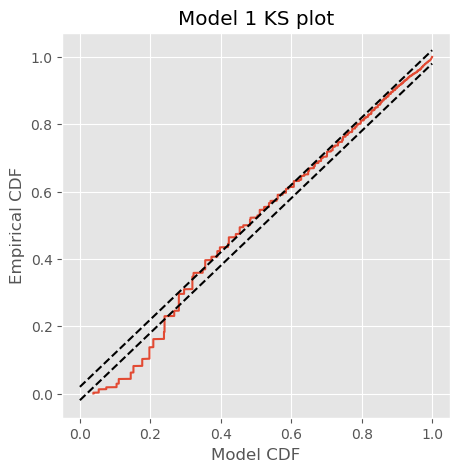

In [26]:
eCDF = ECDF(Z);         # Empirical CDF at Z values.
mCDF = 1 - exp(-eCDF.x) # Model CDF at Z values.
nISI = len(Z)           # Total number of ISIs.

figure(figsize=(5, 5))
plot(mCDF, eCDF.y)       # Create a KS plot
plot([0,1], [0,1] + 1.36 / sqrt(nISI),'k--', ms = 2)  # ... with confidence bounds
plot([0,1], [0,1] - 1.36 / sqrt(nISI),'k--', ms = 2)

xlabel('Model CDF')      # With axes labeled.
ylabel('Empirical CDF')
title('Model 1 KS plot')
show()

The KS plot reveals that the initial model tends to fit the distribution of the larger rescaled ISIs well, but not the shorter ISIs. Therefore, we conclude that Model 1 does not completely capture the structure of the spiking data.

<div class="question">

**Q.** What features of the spiking structure could be missing from this model?

**A.** We have a few options from prior visualizations, including movement direction (left or right) as well as past spiking history. We may improve the model by incorporating either (or both) features.

</div>

### Refining the Model: Movement Direction

With an eye toward improving the initial model, we first visualize the impact of movement direction on Model 1. We create a column vector for the design matrix that indicates the trial movement direction for each time step:

In [27]:
IDir = repeat(direction == 1, nTime)

<div class="question">
    
**Q.** [Above](#repeatvtile) we used the `tile()` function to replicate the vector `t` in order to fit Model 1. This time, we used the function `repeat()`. See if you can figure out what each function does and why we needed a different one this time.
    
</div>

We could add the variable `xdir` directly to the initial Model 1, and proceed immediately with a model fit. But first let’s examine the point process residuals for Model 1, and whether these residuals depend on the trial movement direction.

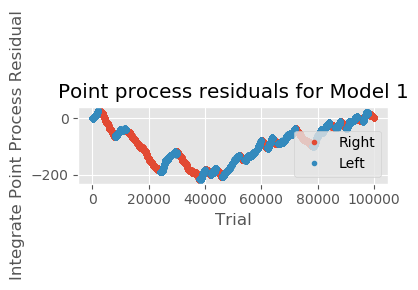

In [28]:
R = cumsum(M1.resid_response);              # Cumulative sum of Model 1 residuals.
plot(where(IDir == 1)[0], R[IDir == 1], '.', label="Right")  # Plot right movement trials,
plot(where(IDir == 0)[0], R[IDir == 0], '.', label="Left")   # ... and left movement trials.

xlabel('Trial')                             # Label axes.
ylabel('Integrate Point Process Residual')
title('Point process residuals for Model 1')
legend()
show()

We find that the integrated residuals tend to increase for left trials, suggesting that Model 1 consistently underestimates the firing rate for these trials, and tend to decrease for right trials, suggesting that Model 1 overestimates the rate for those trials. Including trial direction may therefore help improve the model. Let’s now add the predictor `xdir` to the [initial model](#model:1)<span class="thumb"><sup>eq</sup><img src="imgs/model1.png"></span> to create the second model,<a id="model:2"></a>

$$
  \lambda(t) = \exp\big(\beta_0 + \beta_1 I_\text{move}(t) + \beta_2 I_\text{dir}(t)\big),
  \tag{Model 2}
$$

and fit the model in Python:

In [29]:
glmdata['IDir'] = IDir                 # Add direction information to the glm dataframe
M2 = smf.glm('spikes ~ IMove + IDir',  # Model 2 formula
             data=glmdata,             # ... supply the data,
             family=Poisson()).fit()   # ... and fit the model.
M2.summary()                           # Show results of the fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18843.
Date:                Sat, 13 Jun 2020   Deviance:                       28293.
Time:                        17:58:46   Pearson chi2:                 9.52e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.0228      0.025   -119.359      0.000      -3.072      -2.973
IMove[T.True]     0.3441      0.030     11.617      0.000       0.286       0.402
IDir[T.True]     -0.5090      0.030    -16.891      0.000      -0.568      -0.450
=================================================================================
"""

In [30]:
print(exp(M2.params))  # Look at our new parameters

Intercept        0.048667
IMove[T.True]    1.410678
IDir[T.True]     0.601091
dtype: float64


When adding the direction for each trial to the model, we find that the baseline firing rate parameter changes to $\exp(\beta_0) = 0.0487 = 48.7$ spikes/s. The baseline condition now corresponds to the planning period only (`IMove=0`) of trials to the left (`IDir=0`). The modulation due to changing from planning to movement periods&mdash;$\exp(\beta_\text{move})=1.41$&mdash;stays about the same, suggesting a 41% increase in firing during the movement period. The final parameter relates to the modulation when changing from a left trial to a right trial. The modulation of $\exp(\beta_\text{direction})=0.6011$ indicates that on right trials the firing rate is reduced by about 40%. Let’s check the significance of this last parameter (via a Wald test):

In [31]:
M2.pvalues

Intercept        0.000000e+00
IMove[T.True]    3.386554e-31
IDir[T.True]     5.281829e-64
dtype: float64

We find $p_\text{direction} = 5.28\times 10^{-64}$ and conclude that the decrease in firing rate is highly significant. Finally, let’s construct a KS plot for Model 2:

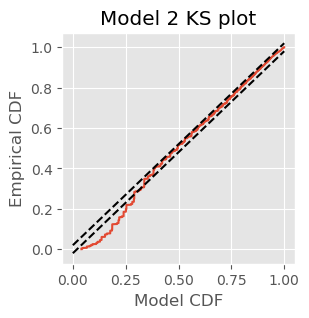

In [32]:
lambda2 = M2.predict(glmdata)          # Predict firing rate of Model 2
spikeindex = where(glmdata.spikes)[0]  # Find the spikes.
                                       # Compute the rescaled waiting times.
Z = [sum(lambda2[a:b])                 # Sum firing rate,
     for a, b in zip(hstack((0, spikeindex[:-1])), spikeindex)]  # ... over each ISI.

eCDF = ECDF(Z);                        # Empirical CDF at Z values.
mCDF = 1 - exp(-eCDF.x)                # Model CDF at Z values.
N = len(Z)                             # Total number of ISIs.

figure(figsize=(3,3))
plot(mCDF, eCDF.y)                     # Create a KS plot
plot([0,1], [0,1] + 1.36 / sqrt(N),'k--', ms = 2)  # ... with confidence bounds,
plot([0,1], [0,1] - 1.36 / sqrt(N),'k--', ms = 2)
xlabel('Model CDF')                    # ... and axes labeled.
ylabel('Empirical CDF')
title('Model 2 KS plot')
show()

<div class="question">
    
**Q.** Compare the KS plot for Model 2 to the [KS plot for Model 1](#fig:ks1). Does the updated model provide an improvement over the original model?

**A.** This KS plot of Model 2 looks similar to that of Model 1. We observe some improvements at intermediate rescaled ISIs, but we are still seeing too few small rescaled ISIs. The updated model represents a slight improvement over the first model but is still well outside the confidence bounds of the KS plot.
</div>

<div style="width:60%; margin: auto">
    <span style="width:50%; float: left"><img src="imgs/ks1.png"></span>
    <span style="width:50%; float: left"><img src="imgs/ks2.png"></span>
</div>
<div style="clear: both; display: table"></div>

<div class="question">
    
**Q.** What other covariates could we add to improve the model?

**A.** The previous autocovariance and spectral analysis suggests that another feature of these data relates to history-dependent spiking. Perhaps we should add columns to the design matrix that depend on past values of the spiking activity.

</div>

## Refining the Model: History Dependence<a id="history-dependence"></a>

Up to this point, we have used Poisson regression models for the spiking data that did not incorporate any history-dependent terms. For those models, the number of spikes in each of the small discrete-time bins is assumed to have a Poisson distribution, and the number of spikes in any two nonoverlapping bins is assumed to be independent. A simple result from probability theory is that the sum of independent Poisson random variables also has a Poisson distribution. Therefore, for those previous models, the number of spikes over multiple time bins, which is the sum of the number of spikes in each bin, still has a Poisson distribution, and all those previous models would be considered Poisson process models.

Now, we would like to add predictors to the model related to the past history of spiking. Thus, we do not expect the number of spikes in nonoverlapping bins to be independent; a spike at the current time will change the probability of seeing a spike in the near future. Even if the number of spikes in a small time bin is assumed to be Poisson, it is no longer the case that the number of spikes in any larger interval will be Poisson. Thus, we would no longer call the resulting spike train a Poisson process. We still use the notation $\lambda(t)$ to represent the expected number of spikes in the $t^{th}$ time bin, but this is no longer called a Poisson rate function. Instead, we call it the **conditional intensity function** and write $\lambda(t|H_t)$, where $H_t$ represents the past history of spiking.

There are many different functions of past spiking that we could use in the model. The simplest option is to use the binned spike train itself, lagged by different amounts of time. Mathematically, we are building a probability model for $\Delta N_i$ as a function of $\Delta N_{i-j}$ for $j = 1,\dots,k$ for some model order $k$.

How should we select the model order? We return to this question later and propose principled approaches to create *parsimonious* models&mdash;models that fit the data well with as few parameters as possible. But we start by selecting a model order based on spectral analysis. We found a peak in the spectral density during the planning period at 15–20 Hz. A history-dependent model that extends to lags of 70 ms should be able to capture rhythms above 15 Hz. Let’s therefore define a variable `ordK` to represent the model order:

In [33]:
ordK = 70  # Define the model order

To predict the spiking at the current time, we need to observe the spiking history up to `ordK` lags in the past. Therefore, we make a new dataframe, `glmHist`, including data from starting from index `ordK` (recall that Python uses 0-indexing, so index $n$ is actually the $[n+1]^{th}$ element in the array). We then insert a new column with the spiking history for each lag.

In [34]:
for k in range(1, ordK + 1):  # For each lag,
                              # ... scroll the spiking history forward.
    glmdata['lag{:02d}'.format(k)] = roll(glmdata.spikes, k)  

# Add a Time column to glmdata so we can filter by time
glmdata['Time'] = tile(t, nTrial)

# Create a variable to reference only those times in glmdata that are >= ordK
glmHist = glmdata.loc[lambda d: d['Time'] > t[ordK]]
# Alternative:
# ... Uncomment the following to filter glmdata using .drop() instead of .loc
# glmHist = glmdata.drop(index=where(glmdata.Time < t[ordK])[0])

glmHist.head()

,IMove,spikes,IDir,lag01,lag02,lag03,lag04,lag05,lag06,lag07,...,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,Time
71,False,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-929
72,False,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-928
73,False,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-927
74,False,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-926
75,False,0,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-925


<div class="python-note">
    
**A note on copying variables in Python.**
To create the variable `glmHist` in the code above, we filtered the dataframe (`glmdata`) using either `loc` or `drop()`. If you try to manipulate `glmHist` directly, you will get an error (although currently Python does some things behind the scenes to allow this). This is because when we created `glmHist`, we did not actually create a new object in the computer's memory&mdash;we created a new reference to the already existing object. For a demonstration, try the following:

    breakfast = {'ham': 'eggs'}
    lunch = breakfast
    lunch['ham'] = 'sandwich'
    print(breakfast)

You should find that `breakfast = {'ham': 'sandwich'}`. Even though we did not change `breakfast` explicitly, the contents still changed. This is because certain objects in Python are *mutable*, which means they can be changed in memory.

In Python, when you assign a value to a variable, the value gets stored at a specific address in the machine's memory, and the variable points to that address. If you assign one variable to another, e.g. `lunch = breakfast`, you are in fact giving `lunch` the address indicated by `breakfast`. Try this:

    print(id(lunch))
    print(id(breakfast))
    
You should see the same value printed twice. If `breakfast` is the address to an *immutable* object like an **int** or a **string**, then changing the value of `breakfast` (or any other variable pointing to that address) forces the variable to point to a new address&mdash;immutable objects cannot be changed (mutated) in memory.

On the other hand, if `breakfast` is the address to a *mutable* object like a **dictionary** or a **list**, then the value of the object will change in memory, and `breakfast` will continue to point to the same address. This is why in the example above, changing `lunch` also changes `breakfast`. Both variables point to the same address and changes to the dictionary object result in changes at that location in memory.

If this seems confusing, don't worry. When you want to make a true copy in memory that you can safely manipulate, simply include the constructor function for the object type. In the `breakfast` example, use `lunch = dict(breakfast)` since `breakfast` is a dictionary. In our code above, we could have used `df()` (our imported abbreviation for `pandas.DataFrame()`) to create a new dataframe. 

    glmHist = df(glmdata.loc[lambda d: d['Time'] >= t[ordK]])

Other mutable datatypes include **lists** and **arrays** (`list()`, `array()`). 

For a more thorough discussion of mutable and immutable objects see <a href="https://towardsdatascience.com/https-towardsdatascience-com-python-basics-mutable-vs-immutable-objects-829a0cb1530a" target="blank">here</a>.

</div>

<div class="question">
    
**Q.** Consider the variable `glmHist`. Can you explain why we included only times greater than or equal to `t[ordK]`?

</div>

We can now include the history in the GLM as follows:

In [35]:
formula = ('spikes ~' +              # Observed spikes as a function of ...
           '+'.join(glmHist.drop(columns='spikes').columns))  # ... all other columns
M3 = smf.glm(formula,                # Fit a glm using the formula,
             data=glmHist,           # ... on the data with spiking history,
             family=Poisson()).fit() # ... using a Poisson GLM.
M3.summary()                         # Summary of fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:                96450
Model:                            GLM   Df Residuals:                    96376
Model Family:                 Poisson   Df Model:                           73
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17967.
Date:                Sat, 13 Jun 2020   Deviance:                       26792.
Time:                        17:58:52   Pearson chi2:                 9.16e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.0622      0.046    -66.090      0.000      -3.153      -2.971
IMove[T.True]     0.3665      0.060      6.118      0.000       0.249       0.484
IDir[T.True]     -0.4989      0.034    -14.883      0.000      -0.565      -0.433
lag01            -1.5569      0.133    -11.664      0.000      -1.818      -1.295
lag02            -1.2337      0.115    -10.710      0.000      -1.459      -1.008
lag03            -0.4937      0.082     -5.993      0.000      -0.655      -0.332
lag04             0.0471      0.066      0.717      0.473      -0.082       0.176
lag05             0.3924      0.058      6.807      0.000       0.279       0.505
lag06             0.5639      0.055     10.324      0.000       0.457       0.671
lag07             0.4368      0.059      7.440      0.000       0.322       0.552
lag08             0.2545      0.064      3.998      0.000       0.130       0.379
lag09             0.0181      0.069      0.261      0.794      -0.118       0.154
lag10             0.0555      0.066      0.835      0.404      -0.075       0.186
lag11             0.0277      0.066      0.418      0.676      -0.102       0.157
lag12            -0.0009      0.067     -0.014      0.989      -0.132       0.130
lag13             0.0586      0.065      0.901      0.367      -0.069       0.186
lag14            -0.0416      0.069     -0.605      0.545      -0.176       0.093
lag15             0.0076      0.067      0.113      0.910      -0.124       0.139
lag16            -0.0748      0.070     -1.074      0.283      -0.211       0.062
lag17             0.0400      0.066      0.608      0.544      -0.089       0.169
lag18            -0.1212      0.071     -1.708      0.088      -0.260       0.018
lag19            -0.0658      0.069     -0.954      0.340      -0.201       0.069
lag20            -0.1430      0.072     -1.997      0.046      -0.283      -0.003
lag21            -0.1078      0.070     -1.533      0.125      -0.246       0.030
lag22             0.0056      0.067      0.084      0.933      -0.125       0.136
lag23            -0.0420      0.068     -0.614      0.539      -0.176       0.092
lag24            -0.1141      0.071     -1.598      0.110      -0.254       0.026
lag25            -0.0682      0.070     -0.977      0.329      -0.205       0.069
lag26            -0.1026      0.071     -1.444      0.149      -0.242       0.037
lag27            -0.0415      0.069     -0.602      0.547      -0.177       0.094
lag28             0.0555      0.066      0.843      0.399      -0.074       0.185
lag29             0.0178      0.067      0.265      0.791      -0.114       0.150
lag30            -0.0850      0.071     -1.200      0.230      -0.224       0.054
lag31            -0.0865      0.071     -1.222      0.222      -0.225       0.052
lag32            -0.0393      0.069     -0.571   

This model would have a total of 73 parameters—one intercept parameter, one movement parameter, one direction parameter, and 70 parameters representing the columns of the history matrix. Mathematically,

$$
  \tag{Model 3}
  \lambda\big(t | H(t)\big) = 
  \exp\big(
      \beta_0 + 
      \beta_1 I_\text{move}(t) +
      \beta_2 I_\text{dir}(t) +
      \sum_{j=1}^{70} \beta_{2+j}\Delta N_{t-j}
  \big).
$$

However, Model 3 implies that the influences of the trial period ($I_{dir}(t)$) and of the past history ($\Delta N_{t-j}$) are multiplicatively separable; that is, that the only difference between the planning and movement period is a change in the average firing rate and the spike rhythms are the same in both periods. The autocovariance and spectral analyses suggest that the influence of past spiking differs between these trial periods. Therefore, we should instead construct a model that has an interaction between the `Imove` and `lag` variables. We do this by including columns that represent the product of these two variables. Mathematically, we propose a model of the form
<a id="eq:model4"></a>
    
$$
  \tag{Model 4}
  \begin{eqnarray}
  \lambda\big(t | H(t)\big) &=& 
  \exp\bigg(
      \beta_0 + 
      \beta_1 I_\text{move}(t) +
      \beta_2 I_\text{dir}(t) + \\ && \qquad
      \sum_{j=1}^{70}
      \big[
      \big(\mathbb{1} - I_\text{move}(t)\big)\beta_{1 + 2j} + 
          I_\text{move}(t)\beta_{2 + 2j}
      \big]
  \bigg)
  \end{eqnarray}
$$

Model 4 has 143 parameters&mdash;one intercept parameter, one parameter for each of the movement and direction indicator variables, 70 parameters describing the history dependence in the planning period, and 70 more parameters describing the history dependence in the movement period. Whenever we construct a point process model that includes history dependence, we call it a conditional intensity model rather than a rate model. To fit this model in Python, we will take advantage of the dataframe structure using the `filter()` method:

In [36]:
# Create a string with all lag columns joined by plus signs
lagColumns = ' + '.join(glmHist.filter(like='lag', axis=1))

# Write a formula modeling the spikes as a function of IMove, IDir and the 
# ... cross-terms (:) of IMove and the lag columns
formula = 'spikes ~ IMove + IDir + IMove : ({0})'.format(lagColumns)

# Fit the model
M4 = smf.glm(formula=formula, data=glmHist, family=Poisson()).fit()
M4.summary()  # Summarize the fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:                96450
Model:                            GLM   Df Residuals:                    96307
Model Family:                 Poisson   Df Model:                          142
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17889.
Date:                Sat, 13 Jun 2020   Deviance:                       26637.
Time:                        17:59:10   Pearson chi2:                 9.14e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.0339      0.053    -56.797      0.000      -3.139      -2.929
IMove[T.True]          0.3221      0.062      5.154      0.000       0.200       0.445
IDir[T.True]          -0.5012      0.034    -14.906      0.000      -0.567      -0.435
IMove[False]:lag01    -2.1004      0.303     -6.940      0.000      -2.694      -1.507
IMove[True]:lag01     -1.3948      0.149     -9.364      0.000      -1.687      -1.103
IMove[False]:lag02    -1.1973      0.194     -6.162      0.000      -1.578      -0.816
IMove[True]:lag02     -1.2779      0.143     -8.933      0.000      -1.558      -0.998
IMove[False]:lag03    -0.3466      0.131     -2.648      0.008      -0.603      -0.090
IMove[True]:lag03     -0.6043      0.106     -5.701      0.000      -0.812      -0.397
IMove[False]:lag04     0.0378      0.112      0.337      0.736      -0.182       0.257
IMove[True]:lag04      0.0271      0.081      0.334      0.738      -0.132       0.186
IMove[False]:lag05     0.2167      0.106      2.048      0.041       0.009       0.424
IMove[True]:lag05      0.4501      0.069      6.530      0.000       0.315       0.585
IMove[False]:lag06     0.4212      0.098      4.308      0.000       0.230       0.613
IMove[True]:lag06      0.6054      0.066      9.172      0.000       0.476       0.735
IMove[False]:lag07     0.3714      0.102      3.659      0.000       0.172       0.570
IMove[True]:lag07      0.4547      0.072      6.310      0.000       0.313       0.596
IMove[False]:lag08     0.1963      0.110      1.791      0.073      -0.018       0.411
IMove[True]:lag08      0.2716      0.078      3.471      0.001       0.118       0.425
IMove[False]:lag09     0.0774      0.115      0.676      0.499      -0.147       0.302
IMove[True]:lag09     -0.0261      0.087     -0.298      0.765      -0.197       0.145
IMove[False]:lag10     0.0594      0.114      0.519      0.604      -0.165       0.284
IMove[True]:lag10      0.0438      0.082      0.536      0.592      -0.116       0.204
IMove[False]:lag11    -0.0644      0.120     -0.535      0.592      -0.300       0.171
IMove[True]:lag11      0.0525      0.079      0.661      0.509      -0.103       0.208
IMove[False]:lag12    -0.0984      0.122     -0.808      0.419      -0.337       0.140
IMove[True]:lag12      0.0235      0.080      0.294      0.769      -0.133       0.180
IMove[False]:lag13     0.1273      0.110      1.161      0.246      -0.088       0.342
IMove[True]:lag13      0.0178      0.081      0.220      0.826      -0.141       0.176
IMove[False]:lag14     0.0200      0.117      0.171      0.864      -0.209       0.248
IMove[True]:lag14     -0.0673      0.085     -0.790      0.430      -0.234       0.100
IMove[False]:lag15     0.1307      0.111      1.181      0.238      -0.086       0.348
IMove[True]:lag15     -0.0581      0.0

In the first line, we created the portion of the `formula` variable that includes the history terms. The `filter()` method can be used to filter rows or columns of a dataframe according to their names (use `df.filter?` for details). In this case, we asked for all column names that include the phrase `'lag'`. In the second line, we compose the formula as we have before except this time we include *cross-terms*. Cross-terms are the product of two predictor variables. There are two ways to include cross-terms in a formula: `*` and `:`. The asterisk (`*`) indicates individual terms in addition to cross-terms; the colon (`:`) indicates that we would like to include only the cross terms.

<div class="question">
    
**Q.** What is a shorter way to call the following formula?

    spikes ~ IMove + IDir + lag01 + IMove:IDir + IMove:lag01 + IDir:lag01 + IMove:IDir:lag01
    
**A.** Because we want to model `spikes` on all individual and cross-terms, we can write

    spikes ~ IMove*IDir*lag01

Moreover, if we wanted to exclude a specific term - for example, `IMove:IDir:lag01`- we could write

    spikes ~ IMove*IDir*lag01 - IMove:IDir:lag01
    
</div>

Let’s examine the exponentiated values directly. For the first three:

In [37]:
# Examine the first three exponentiated values of Model 4
exp(M4.params[:3])

Intercept        0.048126
IMove[T.True]    1.380011
IDir[T.True]     0.605787
dtype: float64

Since Model 4 has 140 additional parameters related to history dependence, inspecting these printed values directly would be too overwhelming. Instead, let’s plot their exponentiated values as a function of lag for each period: <a id="fig:M4params"></a>

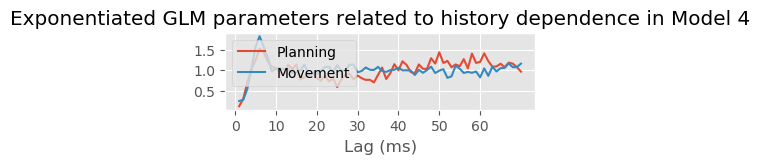

In [38]:
plot(range(1, ordK + 1), 
     exp(M4.params[3::2]), 
     label='Planning')     # Plot the planning parameters.

plot(range(1, ordK+1), 
     exp(M4.params[4::2]), 
     label='Movement')     # Plot the movement parameters.

xticks(range(0, 70, 10))   # With axes labeled.
xlabel('Lag (ms)')
legend()
title('Exponentiated GLM parameters related to history dependence in Model 4')

savefig('imgs/fig-M4params.png')
show()

Each of these values represents a modulation to the firing intensity when a previous spike has occurred at the given lag. For both periods, the value at lag 1 ms is near zero, suggesting that the probability of spiking again immediately after a previous spike is greatly reduced—the neuron is refractory. At lags greater than 1 ms, the probability of spiking now is increased when there is a spike at the given lag. For example, if there is a spike 6 ms in the past during the movement period, the probability of spiking is modulated by about 1.8, or it increases by about 80%. A modulation value near 1 suggests no effect on the spike intensity related to a spike at that lag. For the movement period, we see a refractory period followed by a period of increased intensity 6 ms after a spike. However, any spiking 10 ms in the past or longer appears to have no effect on the current spiking intensity. During the planning period, we see a similar pattern of refractoriness followed by increased intensity up to lag 10 ms. At longer lags, however, we see a pattern of decreased spiking probability about 15–35 ms after a spike, followed by increased spiking probability about 45–65 ms after a spike. The parameter values for these periods suggest that the modulation for these lags is relatively small, about a 10%–15% decrease or increase in the firing intensity.

<div class="question">
    
**Q.** Are these history effects statistically significant?

**A.** One approach we could take is to visualize the p-values (based on the Wald t- test) for each parameter. Since it can be hard to tell visually whether p-values are sufficiently close to zero, let’s plot the negative of the natural logarithm of the p-values. Any value of the negative log above 3 indicates a p-value below 0.05. In Python,

</div>

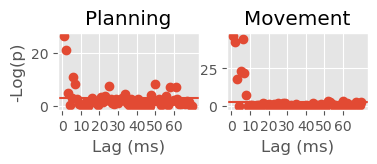

In [39]:
_, a = subplots(1, 2)                   # Create a figure with two subplots
a[0].plot(range(1, ordK + 1), 
          -log(M4.pvalues[3::2]), 'o')  # Plot the planning p-values.
a[0].axhline(3)                         # Indicate significance level,
a[0].set_xticks(range(0, 70, 10))       # ... over a range of lags,
a[0].set_xlabel('Lag (ms)')             # ... with axes labeled.
a[0].set_ylabel('-Log(p)')
a[0].set_title('Planning')

a[1].plot(range(1, ordK + 1), 
          -log(M4.pvalues[4::2]), 'o')  # Plot the movement p-values.
a[1].axhline(3)                         # Indicate significance level.
a[1].set_xticks(range(0, 70, 10))       # ... over a range of lags,
a[1].set_xlabel('Lag (ms)')             # ... with axes labeled.
a[1].set_title('Movement')
show()

We see that for both the planning and movement periods, the p-values corresponding to lags up to about 8 ms tend to be significant. For the movement period, most of the parameters for lags above 8 ms do not suggest significant modulation. For the planning period, we find a few parameters for higher lags that are significant on their own. However, in this case we have to be careful about multiple comparisons. As discussed in <a href="08" target="_blank">notebook 8</a>, if we control the probability of a single test or comparison being significant by chance at 0.05, then after performing multiple tests or comparisons, the probability that any of them are deemed significant by chance becomes much higher. For 140 independent comparisons, even if no effects are actually present, the probability of finding at least one to be significant by chance is $1 - 0.95^{140} = 0.99$.

A common approach for dealing with multiple comparisons is the Bonferroni correction method, where instead of setting the significance level to control for the probability of a single significant result by chance, we divide by the total number of comparisons to control for the probability of having any comparison significant by chance. In this case, the corrected significance level would be 0.05/140 = 0.00036. The negative log of this corrected significance level is about 8. So, in the figure above, we would declare significant only points above 8. Of the parameters corresponding to lags above 10 ms, only the one at lag 50 for the planning period would remain significant.

Bonferroni’s method is often much more conservative than necessary. In this case, we can try another option. Instead of 140 separate tests for each lag in each period, we can construct a single test to answer a question of direct interest: Is there a significant difference between the complete sets of history parameters in the planning and movement periods? In <a href="09" target="_blank">notebook 9</a>, we discussed maximum likelihood ratio tests (MLRTs) for point process models. We showed that for nested models (where one model can be made equivalent to the other by setting some parameters to specific values), under the null hypothesis that the data arise from the smaller model, the difference in the deviance between the two models should have a chi-square distribution with the number of degrees of freedom equal to the number of extra parameters in the larger model. In this case, let’s compare Model 3, for which the history dependence is the same for the planning and movement periods, with Model 4. To compute the p-value for this test in Python,

In [40]:
pval = 1 - chi2.cdf(M3.deviance - M4.deviance, ordK)
pval

2.1893430623975974e-08

<div class="question">
    
**Q.** Why do we set the second input to the function `chi2.cdf()` to `okdK`?
    
</div>

We find `pval = 2.3190e-08`, and we would be very unlikely to see this result if Model 3—the model with identical history dependence structure—were correct.
Finally, let’s construct a KS plot to see how well Model 4 fits the data. When we introduced the time-rescaling theorem in <a href="09" target="_blank">notebook 9</a>, we assumed that the data came from a Poisson process. Now that we are modeling history-dependent point processes, we need to make a slight update to the time-rescaling theorem:


<div class="math-note" id="time-rescaling-history-dependent">
    
**Time-Rescaling Theorem for History-Dependent Point Processes.** 

Let $S_1 , S_2 , \ldots , S_n$ be a collection of spike times from any point process with conditional intensity function $\lambda(t|H_t)$. Let

$$
  Z_1 = \int_0^{S_1} \lambda(t | H_t)dt
  \quad
  \text{and}
  \quad
  Z_i =  \int_{S_{i-1}}^{S_i} \lambda(t | H_t)dt,
$$

for $i = 1, \ldots, n$. Then the rescaled variables $Z_1, \ldots, Z_n$, are independent and identically distributed random variables from the exponential distribution with parameter 1.

</div>

This looks nearly identical to the time-rescaling theorem for Poisson processes, with the Poisson rate functions replaced by history-dependent conditional intensity functions. However, the fact that the rescaled times, $Z_i$, are still independent is perhaps more surprising in this case, since the original point process (i.e., $S_1, S_2, \ldots, S_3$) does have history dependence. This result suggests that if we have the right model, we can rescale the spiking process to account for history dependence as well as changes in the firing intensity related to time and other covariates.

Let’s now return to constructing a KS plot to see how well Model 4 fits the data. 

We use `predict()` to compute the model intensity at each time step: <a id="fig:m4ks"></a>

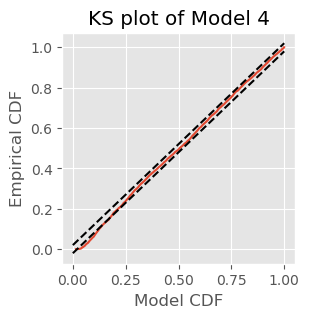

In [41]:
lambda4 = M4.predict(glmHist)          # Compute the model prediction.
spikeindex = where(glmHist.spikes)[0]  # Find the spike times.

Z = [sum(lambda4[a : b])               # Compute the rescaled waiting time,
     for a,b in zip(hstack((0, spikeindex[:-1])), spikeindex)]  # ... for each ISI.

eCDF = ECDF(Z)                         # Empirical CDF
mCDF = 1 - exp(-eCDF.x)                # Model CDF

figure(figsize=(3, 3))                 # Plot the results
plot(mCDF, eCDF.y)
N = len(spikeindex)
plot([0, 1], [0, 1] + 1.36 / sqrt(N), 'k--')
plot([0, 1], [0, 1] - 1.36 / sqrt(N), 'k--')
xlabel('Model CDF')
ylabel('Empirical CDF')
title('KS plot of Model 4')
savefig('imgs/fig-model4ks.png')
show()

<div class="question">

**Q.** Compare the KS plot for Model 4 to the [KS plot for Model 1](#fig:ks1)<span class="sup">fig<img src="imgs/ks1.png"></span>. Does the updated model provide an improvement over the original model?

**A.** We see a substantial improvement in the fit according to the KS plot at smaller rescaled ISIs. The model still does not quite pass the KS test, as can be seen when the KS plot veers outside of the confidence band around the model CDF value of 0.2. However, the inclusion of history dependence has clearly improved the fit of the short rescaled ISIs.

</div>

<div class="question">
    
**Q.** Based on prior visualization analyses, are there any other variables that we could include to further improve the goodness of fit of the model?

</div>

### Choice of Model Order

Before we settle on Model 4, let’s return to the question of how to select the order of a model such as [Model 4](#eq:model4)<span class="sup">eq<img src="imgs/eq10-6.png"></span>. We chose somewhat arbitrarily a model order of 70 for the number of history-dependent terms for both the planning and movement periods, based on the visualization analyses. In subsequent modeling, we found that many of these parameters did not contribute significantly to the model fit on their own. One approach to selecting model order is to start by fitting a higher-order model than you suspect is necessary, and then paring down the parameters that are not significant on their own. In this example, this process would leave a few parameters at small lags for both the planning and movement periods, and one parameter corresponding to a lag of 50 ms for the planning period. However, the MLRT example showed that although many of the history-dependent parameters in this model are not significant on their own, together they substantially improve the model.

Instead of starting with a large model and paring it down, another approach to model selection is to start with a small model and step up the model order while examining the change in goodness-of-fit for each subsequent model. Of course, we have to be careful in comparing goodness-of-fit, since larger models tend to fit the data better even if they do not better predict future data. In <a href="09" target="_blank">notebook 9</a>, we used Akaike’s information criterion (AIC) to compare the goodness-of-fit of models of different sizes. Let’s examine the change in AIC as we change the model order.

Before comparing models of different sizes, let’s consider the classes of models to explore. For the most recent model, we have separate history terms related to the planning and movement periods. The visualization analyses and previous modeling results suggest that the extent to which past spiking influences current spiking likely differs between these two periods. Therefore, let’s fit models with different orders for the history dependence in these separate periods. Mathematically, we would search for the value of the pair, $(p, q)$, that minimizes the AIC of the model

$$
  \lambda(t) = 
  \exp\big[
      \beta_0 + 
      \beta_1I_\text{move}(t) + 
      \beta_2I_\text{dir}(t) + 
      \sum_{j=1}^p \big(\mathbb 1 - I_\text{move}(t)\big)\beta_{2+j}\Delta N_{t-j} + 
      \sum_{j=1}^q \beta_{p + 2 + j}I_\text{move}(t)\Delta N_{t-j}
  \big].
$$

This might be the best choice if the goal were to find the most parsimonious model that captures the full dataset.

Alternatively, we could decide to fix a single value for the model order and force the history-dependent component to be the same size in both periods. In that case, we would find the single value $p$ that minimizes the AIC of the model

$$
  \lambda(t) = 
  \exp\big[
      \beta_0 + 
      \beta_1I_\text{move}(t) + 
      \beta_2I_\text{dir}(t) + 
      \sum_{j=1}^p \big(\mathbb 1 - I_\text{move}(t)\big)\beta_{2+j}\Delta N_{t-j} + 
      \sum_{j=1}^p \beta_{p + 2 + j}I_\text{move}(t)\Delta N_{t-j}
  \big].
$$

This might be the best choice if the goal were to compare the rhythmic spiking features between the planning and movement periods with a parsimonious model, since it allows us to test for differences, as with the preceding MLRT.

In this case, let’s consider a simpler problem: for the data in the planning period alone, let’s find the model order that minimizes the AIC of

$$
  \lambda(t) = 
  \exp\big[
      \beta_0 + 
      \beta_1I_\text{dir}(t) + 
      \sum_{j=1}^p \beta_{1 + j}I_\text{move}(t)\Delta N_{t-j}
  \big].
$$

We will build models of order 1 up to order 100 and compute the AIC for each model. Because we are fitting many models, each with a large dataset, the following code might take a few minutes to run:

In [42]:
maxord = 100                                 # Define the maximum model order.
for k in range(ordK + 1, maxord + 1):        # Add a history column for each lag greater than ordK
    glmdata['lag{:02d}'.format(k)] = roll(glmdata.spikes, k)

planHist = glmdata.loc[lambda d: d['Time'] < 0]  # Isolate the planning period

formula = 'spikes ~ IDir'                    # Initialize the formula,
aic = zeros((maxord,))                       # ... and the variable to store AIC values.

for k in range(maxord):                      # For each model order,
    formula += ' + lag{:02d}'.format(k + 1)  # ... update the formula,
    M = smf.glm(formula=formula,             # ... create the model,
                data=planHist,               # ... supply the planning data,
                family=Poisson()).fit()      # ... fit the model.
    aic[k] = M.aic                           # Store the model AIC.

<div class="math-note">

Recall that the AIC is related to the deviance of the fitted model (modulo a fixed constant) plus 2 times the number of parameters in the model. Therefore, we could also have computed the AIC using
    
    aic[k] = M.deviance + 2 * len(M.params)

</div>

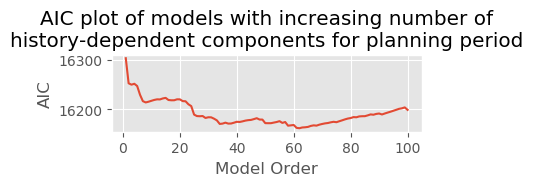

In [43]:
plot(range(1, maxord + 1), aic)  # Plot the AIC,
xlabel('Model Order')            # ... with axes labeled.
ylabel('AIC')
title('AIC plot of models with increasing number of\n' +
      'history-dependent components for planning period')
show()

We see that the AIC drops sharply (with one little blip) from order 1 through order 6, after which the AIC starts to increase. However, as the model order continues to increase, the AIC plot undergoes a number of additional drops around lags of 25–35 ms and around 60 ms, reaching a minimum at a lag of 62 ms. The AIC continues to increase after that point up to lag 100 ms. Of course, it is possible that the AIC undergoes additional drops beyond a lag of 100 ms.

<div class="question">
    
**Q.** Given the AIC results above, what model order would you choose?

</div>

### Refining the Model: Smooth History Dependence
Let’s examine one more approach for constructing a parsimonious model that still captures history dependence in these data. Looking back at the [parameter estimates for Model 4](#fig:M4params)<span class="sup">fig<img src="imgs/fig-M4params.png"></span>, we see that nearby parameters have quite variable estimates. Do we really believe that the influence of a spike 25 ms in the past can be very different from the influence of a spike 26 ms in the past? If not, it might be preferable to define a model with fewer free parameters that guarantees a smooth modulation as a function of lag.

Motivated by this observation, let’s replace the separate terms for each single millisecond lag. We do so with a small set of basis functions on the spiking history that can flexibly capture smooth history dependence structure. Mathematically, we fit a model of the form <a id="eq:model5"></a>

$$
  \tag{Model 5}
  \begin{eqnarray}
  \lambda(t | H_t) &=& 
  \exp\big(
      \beta_0 + 
      \beta_1I_\text{move}(t) +
      \beta_2I_\text{dir}(t)\ + \\ && \quad
      \sum_{j=1}^p 
      \big[
          \big(
              \mathbb 1 - I_\text{move}(t)
          \big)
          \beta_{1+2j} + 
          I_\text{move}(t)\beta_{2 + 2j}
      \big]g_j(H_t)
  \big),
  \end{eqnarray}
$$

where $H_t$ is the full past firing history, and $g_j(H_t)$ is a small collection of basis functions that together provide a smooth influence of the history on the current spiking intensity.

There are many sensible choices for these basis functions. A common choice is a
smoothing spline basis. Here we use a set of Gaussian kernel functions with means at different lags as the basis functions. Mathematically, we set $g_j(H_t) = \sum_\tau\Delta N_{t - \tau}\exp[-(\tau - \mu_j)^2 / (2\sigma^2)]$, where we let $\mu_j = 10j - 15$ for $j = 1,\ldots, 8$, and $\sigma=5$. This choice of basis function is rather arbitrary; Gaussian kernels lack many of the nice properties of other basis functions. In this case, it was primarily chosen for ease of implementation in Python but also because of some simple intuition. The Gaussian kernel provides a way of smoothing the history dependence over a time scale set by the $\sigma$ term. Setting $\sigma = 5$ and spacing the means at 10 ms lags apart ensures that distinct features in the history modulation function will not be closer than about 10 ms in lag.

We construct this set of basis functions in Python as follows:

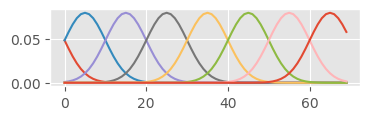

In [44]:
C = array([norm.pdf(arange(-5, ordK, 10), k, 5) for k in range(ordK)])
plot(C)
show()

The result in `C` is a [70 &times; 8] matrix that we will use to convert the previous 70 history columns in `glmdata` into a new set of 8 columns to include in the design matrix.

In [45]:
lags = glmdata.filter(like='lag').columns[:ordK]  # Get the first ordK lags.
basisCols = glmdata.filter(items=lags).dot(C)     # Matrix multiply lags up to ordK by C.

for c in range(C.shape[-1]):                      # Add the new basis columns to glmdata.
    glmdata['b{}'.format(c)] = basisCols[c]
                                                  # Formula to fit spikes with basis vectors.   
formula = 'spikes ~ IMove + IDir + IMove : ({})'.format(
    ' + '.join(glmdata.filter(like='b').columns))

glmHist = glmdata.loc[lambda d: d['Time'] > t[ordK]]
M5 = smf.glm(formula=formula,                     # Create the model,
             data=glmHist,                        # ... exclude the first ordK time points,
             family=Poisson()).fit()              # ... fit the model.
M5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:                96450
Model:                            GLM   Df Residuals:                    96431
Model Family:                 Poisson   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18014.
Date:                Sat, 13 Jun 2020   Deviance:                       26885.
Time:                        18:02:06   Pearson chi2:                 9.11e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.0337      0.053    -56.865      0.000      -3.138      -2.929
IMove[T.True]       0.3279      0.062      5.250      0.000       0.205       0.450
IDir[T.True]       -0.5036      0.034    -14.989      0.000      -0.569      -0.438
IMove[False]:b0   -35.1150      3.161    -11.110      0.000     -41.310     -28.920
IMove[True]:b0    -35.1882      2.239    -15.715      0.000     -39.577     -30.799
IMove[False]:b1     7.6090      0.859      8.858      0.000       5.926       9.293
IMove[True]:b1      8.5543      0.617     13.860      0.000       7.345       9.764
IMove[False]:b2    -2.6924      0.706     -3.811      0.000      -4.077      -1.308
IMove[True]:b2     -2.8550      0.486     -5.871      0.000      -3.808      -1.902
IMove[False]:b3    -2.4755      0.701     -3.532      0.000      -3.849      -1.102
IMove[True]:b3      1.5028      0.455      3.299      0.001       0.610       2.396
IMove[False]:b4    -1.2299      0.669     -1.839      0.066      -2.541       0.081
IMove[True]:b4     -0.2786      0.456     -0.612      0.541      -1.171       0.614
IMove[False]:b5     1.5456      0.622      2.485      0.013       0.326       2.765
IMove[True]:b5      0.1248      0.457      0.273      0.785      -0.772       1.021
IMove[False]:b6     2.1231      0.597      3.554      0.000       0.952       3.294
IMove[True]:b6     -0.9600      0.460     -2.087      0.037      -1.862      -0.058
IMove[False]:b7     1.3616      0.589      2.310      0.021       0.206       2.517
IMove[True]:b7      0.9499      0.429      2.214      0.027       0.109       1.791
===================================================================================
"""

Now let’s plot for this model the modulation in the spiking intensity due to a previous spike at any lag by multiplying the corresponding set of parameters by `C`.<a id="fig:model5"></a>

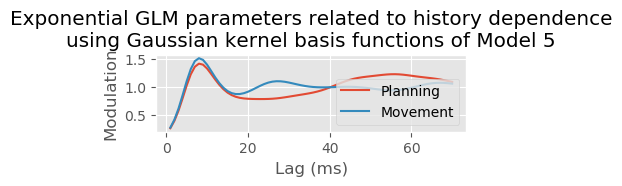

In [46]:
plot(range(1, ordK + 1),  # Plot the planning modulation,
     exp(matmul(C, array(M5.params[3::2]))), 
     label='Planning')
plot(range(1, ordK + 1),  # ... and the movement modulation,
     exp(matmul(C, array(M5.params[4::2]))), 
     label='Movement')

xlabel('Lag (ms)')        # ... with axes labeled.
ylabel('Modulation')
legend()
title('Exponential GLM parameters related to history dependence\n' +
     'using Gaussian kernel basis functions of Model 5')
show()

<div class="question">
    
**Q.** How well does Model 5 fit the data?

</div>

To answer this, let's construct one more KS plot:<a id="fig:m5ks"></a>

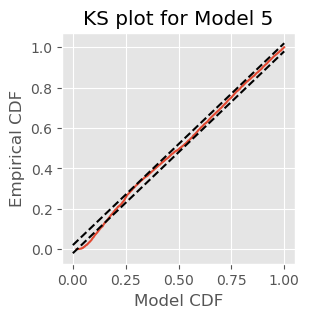

In [47]:
lambda5 = M5.predict(glmHist)
spikeindex = where(glmHist.spikes)[0]

Z = [sum(lambda5[a : b]) 
     for a, b in zip(hstack((0, spikeindex[:-1])), spikeindex)]

eCDF = ECDF(Z)
mCDF = 1 - exp(-eCDF.x)

figure(figsize=(3, 3))
plot(mCDF, eCDF.y)
plot([0, 1], [0, 1] + 1.36 / sqrt(len(Z)), 'k--')
plot([0, 1], [0, 1] - 1.36 / sqrt(len(Z)), 'k--')
xlabel('Model CDF')
ylabel('Empirical CDF')
title('KS plot for Model 5')
savefig('imgs/fig-model5ks.png')
show()

<div class="question">
    
**Q.** Compare the KS plot for Model 5 to the KS plot for Model 4. How does the model with Gaussian kernel basis functions compare to the previous model?

**A.** Model 5 appears very similar to the previous model, even though we are using far fewer parameters. However, Model 5 still does not pass the KS test completely, as can be seen by the KS plot exiting the 95% confidence region at a model CDF value around 0.1.

</div>

<div style="width:70%; margin: auto">
    <span style="width:50%; float: left"><img src="imgs/fig-model4ks.png"></span>
    <span style="width:50%; float: left"><img src="imgs/fig-model5ks.png"></span>
</div>
<div style="clear: both; display: table"></div>

Although Model 5 does not completely pass the KS test, it does capture many of the features that we sought to identify through the analyses. We might therefore accept this as the final model, for the time being, and try to interpret its components. We can always return to the model selection procedure and continue to refine the model if we find that it fails to capture some important features of the data.

[Back to top](#top)

## Drawing Conclusions from the Model<a id="drawing-conclusions"></a>

At last, let’s examine and interpret the Model 5 parameters. Exponentiating the first three, we get:

In [48]:
print('Parameters:')
print(exp(M5.params[:3]))
print()
print('p-values:')
print(M5.pvalues[:3])

Parameters:
Intercept        0.048135
IMove[T.True]    1.388054
IDir[T.True]     0.604345
dtype: float64

p-values:
Intercept        0.000000e+00
IMove[T.True]    1.518398e-07
IDir[T.True]     8.676041e-51
dtype: float64


The best guess for the baseline firing intensity - for the planning period during left trials with no previous spiking in the past 70 ms - is approximately 0.048 spikes/ms, or 48 spikes/s. The firing intensity, excluding the effect of history dependence, increases about `exp(M5.params[1])=1.3881`, or 39%, when we move from the planning period to the movement period. This increase is highly significant (`M5.pvalues[1] = 1.5e-07`) according to the model. The relative firing intensity between left and right trials is `exp(M5.params[2]) = 0.6043`; we find there is an approximate 40% decrease in the firing intensity for right trials as compared to left trials. This difference is again highly significant (`M5.pvalues[2] = 8.7e-51`) according to the model.

In the [estimated modulation due to past spiking in Model 5](#fig:model5)<span class="sup">fig<img src="imgs/fig-model5.png"></span> for both the planning and movement periods, we observe a refractory period followed by a period of bursting (i.e., increased spiking intensity) around 6 ms in both the planning and movement periods. During the planning period, we also observe a notable pattern of decreased firing intensity at 20–30 ms after a previous spike, followed by increased firing intensity at 50–60 ms after a previous spike. This pattern seems absent during the movement period. Are the individual parameters related to this history dependence significant? To address this, let’s plot the $p$-values:

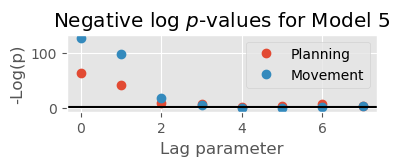

In [49]:
plot(range(8), -log(M5.pvalues[3::2]), 'o', label="Planning") # -Log p-values in planning.
plot(range(8), -log(M5.pvalues[4::2]), 'o', label="Movement") # -Log p-values in movement.
axhline(3, c='k')
ylabel('-Log(p)')
xlabel('Lag parameter')
legend()
title('Negative log $p$-values for Model 5')
show()

For Model 5, all but one of the parameters related to history modulation during the planning period are significant at the 0.05 level. However, this leads to the same multiple comparisons problem discussed earlier. For Model 4 we performed 140 tests, while here we have only 16 tests, far fewer, so the multiplicity problem is slightly reduced but still present. Again, we can avoid this problem by instead focusing on a single test to address the question of whether the history dependence structure differs between the planning and movement periods. Let’s fit a reduced model that uses the same basis functions for history dependence as Model 5 but includes only a single set of parameters for both the planning and movement periods.

In [50]:
formula = 'spikes ~ IMove + IDir + {}'.format(          # Write a formula
    ' + '.join(glmHist.filter(like='b')))               # ... excluding IMove cross-terms
M6 = smf.glm(formula, glmHist, family=Poisson()).fit()  # Fit the model

Next, let’s compute the MLRT statistic as the difference in the deviance between Model 5
and its reduction, and compute its significance based on the chi-square distribution,

In [51]:
p = 1 - chi2.cdf(M6.deviance - M5.deviance, C.shape[-1])
p

2.220446049250313e-16

Once again, we end up with a very significant result that provides confidence that the spiking dynamics really do change between periods. The rhythmic structure that we see during planning is attenuated during the movement period.

[Back to top](#top)

## Summary<a id="summary"></a>

In this case study, we explored a variety of approaches for identifying and quantifying rhythmic spiking dynamics. One key point is that we can think about spike rhythms in terms of how the likelihood of spiking depends on its own history. Many of the most useful visualization tools that we explored, such as the autocorrelation plot and the spectral estimates, implicitly define the covariability of the spiking process with its past. The GLM methods allowed us to model this history dependence explicitly and to explore multiple features of the data simultaneously.

In the STN data, we also saw that rhythmic spiking structure can be subtle and hard to detect if we do not use the proper tools. The dynamic rhythms in these data were nearly impossible to see in raster plots or ISI histograms but became quite apparent in the autocorrelation plot, spectral density estimates, and model fits. Many people think of rhythmic spiking data as being like the beats of a metronome: perfect beats at a specific frequency. But we saw that very subtle changes in the firing probability, perhaps just a 10% increase or decrease at a particular lag, can lead to robust rhythms, as identified by visualization and modeling tools. Real spike rhythms often look more like the examples in this notebook than like the rhythms of a beating metronome.